In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, accuracy_score, f1_score, recall_score, precision_score
)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTENC, SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# 1. Đọc và tiền xử lý dữ liệu
df = pd.read_csv("../dataset/Benh_nhom1.csv")
df = df.drop(columns=["Unnamed: 0", "MABN"])
df["CoBenh"] = df["CoBenh"].map({"Y": 1, "N": 0})

X_raw = df.drop("CoBenh", axis=1).copy()
y = df["CoBenh"]


In [3]:
# 2. Label Encoding cho các biến phân loại
categorical_cols = X_raw.select_dtypes(include='object').columns.tolist()
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_raw[col] = le.fit_transform(X_raw[col])
    le_dict[col] = le


In [4]:
# 3. SMOTENC
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_raw, y)


In [5]:
# 4. Chuẩn hoá
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)


In [6]:
# 5. Chia train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_resampled, test_size=0.3, stratify=y_resampled, random_state=42
)

# Kiểm tra phân bố nhãn
print("\nPhân bố nhãn sau khi tách:")
print("Train:", np.bincount(y_train))
print("Test:", np.bincount(y_test))


Phân bố nhãn sau khi tách:
Train: [389 390]
Test: [168 167]


In [7]:
# 6. Huấn luyện XGBoost
neg_count = sum(y_resampled == 0)
pos_count = sum(y_resampled == 1)
scale_pos_weight_value = neg_count / pos_count if pos_count else 1
print(f"\nScale pos weight: {scale_pos_weight_value:.2f}")

model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_estimators=150,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=scale_pos_weight_value
)
model.fit(X_train, y_train)


Scale pos weight: 1.00


c:\Users\DELL\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:05:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, ...)

In [8]:
# 7. Dự đoán và đánh giá
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=["(0) Không bệnh", "(1) Có bệnh"]))


--- Classification Report ---
                precision    recall  f1-score   support

(0) Không bệnh       0.78      0.71      0.75       168
   (1) Có bệnh       0.73      0.80      0.76       167

      accuracy                           0.76       335
     macro avg       0.76      0.76      0.75       335
  weighted avg       0.76      0.76      0.75       335



In [9]:
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)


--- Confusion Matrix ---
[[120  48]
 [ 34 133]]


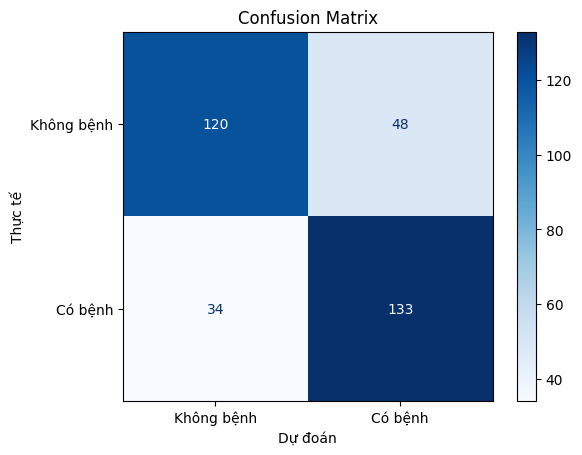

In [10]:
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Không bệnh", "Có bệnh"])
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

In [11]:
# Các chỉ số chính cho lớp 'Có bệnh'
print("\n--- Các độ đo cho lớp âm (CoBenh=0) ---")

f1_0 = f1_score(y_test, y_pred, pos_label=0)
recall_0 = recall_score(y_test, y_pred, pos_label=0)
precision_0 = precision_score(y_test, y_pred, pos_label=0)

print(f"F1-Score:  {f1_0:.4f}")
print(f"Recall:    {recall_0:.4f}")
print(f"Precision: {precision_0:.4f}")


--- Các độ đo cho lớp âm (CoBenh=0) ---
F1-Score:  0.7453
Recall:    0.7143
Precision: 0.7792


In [12]:

# Các chỉ số chính cho lớp 'Có bệnh'
print("\n--- Các độ đo cho lớp dương (CoBenh=1) ---")
f1_1 = f1_score(y_test, y_pred, pos_label=1)
recall_1 = recall_score(y_test, y_pred, pos_label=1)
precision_1 = precision_score(y_test, y_pred, pos_label=1)

print(f"F1-Score:  {f1_1:.4f}")
print(f"Recall:    {recall_1:.4f}")
print(f"Precision: {precision_1:.4f}")


--- Các độ đo cho lớp dương (CoBenh=1) ---
F1-Score:  0.7644
Recall:    0.7964
Precision: 0.7348


In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy = accuracy_score(y_test, y_pred)
precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print("--- Độ đo tổng thể (Weighted Average) ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision (weighted): {precision_weighted:.4f}")
print(f"Recall    (weighted): {recall_weighted:.4f}")
print(f"F1-score  (weighted): {f1_weighted:.4f}")


--- Độ đo tổng thể (Weighted Average) ---
Accuracy:  0.7552
Precision (weighted): 0.7571
Recall    (weighted): 0.7552
F1-score  (weighted): 0.7548


In [14]:
print("\n--- Độ đo tổng thể (Macro Average) ---")
print(f"Precision (macro):    {precision_macro:.4f}")
print(f"Recall    (macro):    {recall_macro:.4f}")
print(f"F1-score  (macro):    {f1_macro:.4f}")


--- Độ đo tổng thể (Macro Average) ---
Precision (macro):    0.7570
Recall    (macro):    0.7553
F1-score  (macro):    0.7549


In [15]:
# ROC AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 0.8283



--- Số lượng nhãn mô hình đã dự đoán ---
Nhãn 0: 154 mẫu
Nhãn 1: 181 mẫu


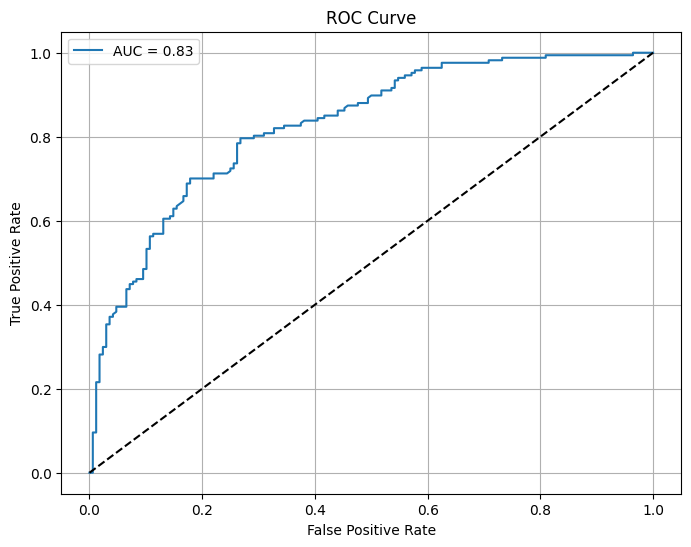

In [16]:
# Kiểm tra nhãn được mô hình dự đoán
unique_preds, pred_counts = np.unique(y_pred, return_counts=True)
print("\n--- Số lượng nhãn mô hình đã dự đoán ---")
for label, count in zip(unique_preds, pred_counts):
    print(f"Nhãn {label}: {count} mẫu")

# Vẽ ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

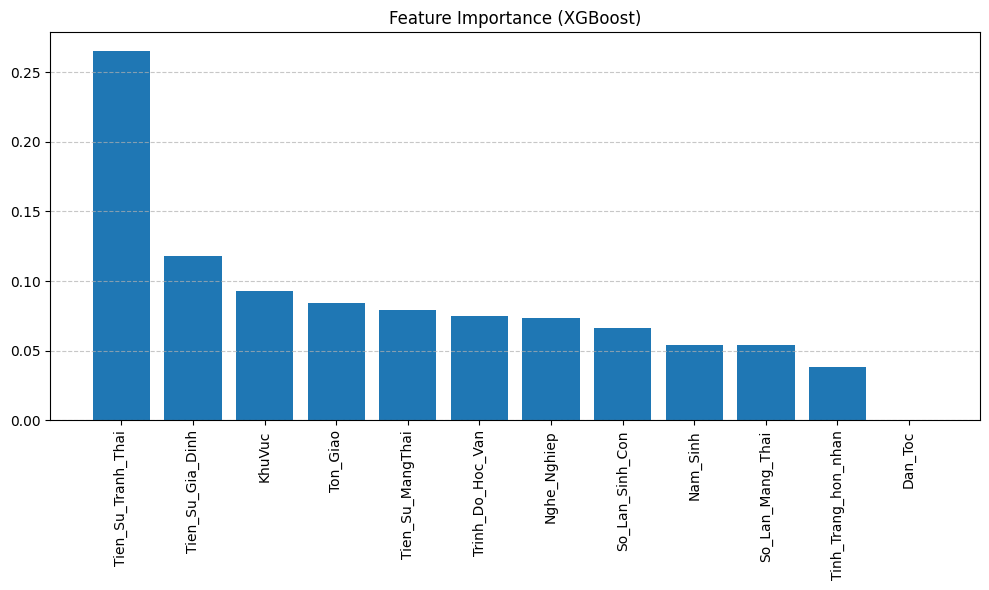

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_raw.columns

plt.title("Feature Importance (XGBoost)")
plt.bar(range(X_raw.shape[1]), importances[indices], align='center')
plt.xticks(range(X_raw.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [18]:
import pickle
# Danh sách tên đặc trưng từ DataFrame trước khi chuẩn hóa
feature_names = X_raw.columns.tolist()

# Lưu danh sách đặc trưng vào file .pkl
# with open("features.pkl", "wb") as f:
#     pickle.dump(feature_names, f)

# print("Đã lưu danh sách đặc trưng vào features.pkl")

# # Đọc lại và in ra để kiểm tra
# with open("features.pkl", "rb") as f:
#     loaded_features = pickle.load(f)

# print("Danh sách đặc trưng đã lưu:")
# print(loaded_features)


In [19]:
# with open("features.pkl", "rb") as f:
#     loaded_features = pickle.load(f)

# print("Danh sách đặc trưng đã lưu:")
# print(loaded_features)


In [20]:
# # Lưu model với đuôi .model
# model.save_model("models/xgb_model.model_1")